##  OBJECTIVE: this project will present the number and percentage of K-12 student enrollment by three ethnicity groups in the past 20 years from 1999 through 2018 school year in Texas, attendance, dropout, and graduation rate by demographic groups in the past twenty years (FY1998-FY2018) in TEXAS by using TEA-AEIS (1998-2012) and TEA-TAPR(2013-2018) public data. 

## DATA: All the data sets used in this project are public data that can be downloaded from TEA website:

     (1) AEIS: Academic Excellence Indicator System (campus level and district level)
         https://rptsvr1.tea.texas.gov/perfreport/aeis/index.html
     (2) TAPR: Texas Academic Performance Reports (campus level and district level)
         https://tea.texas.gov/texas-schools/accountability/academic-accountability/performance-reporting
     (3) Spatial data: http://schoolsdata2-tea-texas.opendata.arcgis.com/

## CONTENT:
    (1) Data Preparation: data exploration, merging, wrangling, aggregation
    (2) Data Visulization: distribution of student counts plotted in static and interactive graphs
    (3) Geographic Illustration of Distribution of K-12 Enrollees by Ethnic Groups 
    (4) Build a web-based Dashboard with Dash

In [18]:
# Load libraries
import numpy as np
import pandas as pd
import re # Regular Expression

from matplotlib import pyplot as plt # visualization
%matplotlib inline

import seaborn as sns # visualization
sns.set(style='whitegrid')

import plotly # visualization, more interactive
import plotly.graph_objs as go 
import plotly.express as px
#from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#init_notebook_mode(connected=True)


import geopandas as gpd # For reading spatial data

import warnings
warnings.filterwarnings('ignore')

### 1) Enrollomement data preparation

In [19]:
# Process AEIS "district" level data from 1999 through 2012 and TAPR district level data from 2013 through 2018.
# We need to extract "District Names" information, which will lated be used in the map of web-based Dashboard 

# The "exec" function can be used to create a datafram/variable name that includes another variable
for i in range(1999,2019,1):
    # load and process AEIS district data
    if i<2012:
        # allow guessing dtypes, and suppress low memory warning by using "low_memory=False"
        exec("dist_" + str(i) + "=pd.read_csv('TEA-AEIS-DATA/year_based/aeisdist" + str(i) + ".csv',low_memory=False)") 
        exec("dist_" + str(i) + "=" + "dist_" + str(i) + "[['district','dname']]")
        exec("dist_" + str(i) + ".rename(columns={'district':'DISTRICT','dname':'DISTNAME'}, inplace=True)")
        exec("dist_" + str(i) + ".to_csv('dist_" + str(i) + ".csv', index=False)")
    elif i==2012:
        exec("dist_" + str(i) + "=pd.read_csv('TEA-AEIS-DATA/year_based/aeisdist" + str(i) + ".csv',low_memory=False)")
        exec("dist_" + str(i) + "=" + "dist_" + str(i) + "[['DISTRICT','DISTNAME']]")
        exec("dist_" + str(i) + ".to_csv('dist_" + str(i) + ".csv', index=False)")
    # load and process TAPR district data
    else:
        exec("dist_" + str(i) + "=pd.read_csv('TEA-TAPR-DATA/tapr_district_" + str(i) + ".csv',low_memory=False)")
        exec("dist_" + str(i) + "=" + "dist_" + str(i) + "[['DISTRICT','DISTNAME']]")
        exec("dist_" + str(i) + ".to_csv('dist_" + str(i) + ".csv', index=False)")      

In [20]:
dist_1999_2018 = pd.concat([dist_2018,
                          dist_2017,
                          dist_2016,
                          dist_2015,
                          dist_2014,
                          dist_2013,
                          dist_2012,
                          dist_2011,
                          dist_2010,
                          dist_2009,
                          dist_2008,
                          dist_2007,
                          dist_2006,
                          dist_2005,
                          dist_2004,
                          dist_2003,
                          dist_2002,
                          dist_2001,
                          dist_2000,
                          dist_1999],axis=0)

In [21]:
dist_1999_2018 = dist_1999_2018.drop_duplicates(keep='first')
dist_1999_2018.to_csv('dist_1999_2018.csv',index=False)

In [22]:
# Process AEIS "campus" level data from 1999 through 2012 and TAPR district level data from 2013 through 2018.

# Note1: 
# (1) Asian student has been splitted into two categories(Asian & Pacific islander) starting from 2011
# (2) A new category "two or more ethnicities" was added starting from 2011
# (3) The ethnicity cateogry "Native American" has the fewest, and lots of them reported "two or more" category in 2011 and later
# (4) 'CPETALLC' indicates all enrollees count, 'CPETBILC','CPETHISC','CPETWHIC','CPETASIC','CPETPCIC','CPETINDC','CPETTWOC'
# So in this research, only three ethnicity groups are considered, which are "Black","White","Hispanic"

enr_col_names = ['CAMPUS','CPETALLC',
             'CPETBLAC','CPETHISC','CPETWHIC',
             'CPETBILC','CPETVOCC','CPETECOC','CPETGIFC','CPETSPEC','CPETGKNC',
             'CPETGPKC','CPETG01C','CPETG02C','CPETG03C','CPETG04C','CPETG05C','CPETG06C',
             'CPETG07C','CPETG08C','CPETG09C','CPETG10C','CPETG11C','CPETG12C'
              ]
lowercase_col_names = [x.lower() for x in enr_col_names]

In [23]:
for i in range(1999,2019,1):
    if i < 2012:
        # load and process AEIS-cstud data
        exec("campus_stu_enr_" + str(i) + "=" + "pd.read_csv('TEA-AEIS-DATA/year_based/aeiscamp" + str(i) + ".csv')")
        # keep the useful variables only
        exec("campus_stu_enr_count_" + str(i) + "=" + "campus_stu_enr_" + str(i) + "[lowercase_col_names]")  
        exec("campus_stu_enr_count_" + str(i) + ".columns" + "=" + "map(str.upper," + "campus_stu_enr_count_" + str(i) + ".columns)")
    
    elif i >= 2012:
        # load and process AEIS-2012-cstud data
        if i == 2012:
            exec("campus_stu_enr_" + str(i) + "=" + "pd.read_csv('TEA-AEIS-DATA/year_based/aeiscamp" + str(i) + ".csv')") 
        
        # load and process TAPR-cstud data
        else:
            exec("campus_stu_enr_" + str(i) + "=" + "pd.read_csv('TEA-TAPR-DATA/tapr_campus_" + str(i) + ".csv')")
        
        # keep the useful variables only
        exec("campus_stu_enr_count_" + str(i) + "=" + "campus_stu_enr_" + str(i) + "[enr_col_names]") 
    
    # Create a new "school year" variable 
    exec("campus_stu_enr_count_" + str(i) + "['SCHOOL_YR']" + "=" + str(i))
    exec("campus_stu_enr_count_" + str(i) + ".to_csv('campus_stu_enr_count_" + str(i) + ".csv',index=False)")   
    
    # Delete the useless dataframe from memory
    exec("del campus_stu_enr_" + str(i))
    exec("campus_stu_enr_count_" + str(i) + "=" + "pd.read_csv('campus_stu_enr_count_" + str(i) + ".csv')")

In [24]:
# Concatenate all the data from 1999 through 2018 together
campus_stu_enr_count_1999_2018 = pd.concat([campus_stu_enr_count_1999,
                                            campus_stu_enr_count_2000,
                                            campus_stu_enr_count_2001,
                                            campus_stu_enr_count_2002,
                                            campus_stu_enr_count_2003,
                                            campus_stu_enr_count_2004,
                                            campus_stu_enr_count_2005,
                                            campus_stu_enr_count_2006,
                                            campus_stu_enr_count_2007,
                                            campus_stu_enr_count_2008,
                                            campus_stu_enr_count_2009,
                                            campus_stu_enr_count_2010,
                                            campus_stu_enr_count_2011,
                                            campus_stu_enr_count_2012,  
                                            campus_stu_enr_count_2013,
                                            campus_stu_enr_count_2014,
                                            campus_stu_enr_count_2015,
                                            campus_stu_enr_count_2016,
                                            campus_stu_enr_count_2017,
                                            campus_stu_enr_count_2018],
                                            axis=0)

In [25]:
# Delete useless dataframe from memory
for i in range(1999,2019,1):
    exec("del campus_stu_enr_count_" + str(i))

In [26]:
# Export the data
campus_stu_enr_count_1999_2018.to_csv('campus_stu_enr_count_1999_2018.csv',index=False)

In [27]:
# Load the data in memory
campus_stu_enr_count_1999_2018 = pd.read_csv('campus_stu_enr_count_1999_2018.csv')

In [28]:
# Data exploration
print(campus_stu_enr_count_1999_2018.shape)
print(campus_stu_enr_count_1999_2018.head())
print(campus_stu_enr_count_1999_2018.info())
print(campus_stu_enr_count_1999_2018.describe())

(163205, 25)
    CAMPUS  CPETALLC  CPETBLAC  CPETHISC  CPETWHIC  CPETBILC  CPETVOCC  \
0  1902001       192        17         1       171         0       138   
1  1902041       157        23         2       132         0        48   
2  1902103       275        36        11       225         5         0   
3  1903001       330        24         7       298         0       193   
4  1903041       247        23         4       218         0       119   

   CPETECOC  CPETGIFC  CPETSPEC  ...  CPETG04C  CPETG05C  CPETG06C  CPETG07C  \
0        31        16        35  ...         0         0         0         0   
1        40        11        29  ...         0         0        48        48   
2        83        15        33  ...        50        42         0         0   
3        94        36        55  ...         0         0         0         0   
4        91        19        49  ...         0         0        78        93   

   CPETG08C  CPETG09C  CPETG10C  CPETG11C  CPETG12C  SCHOOL_Y

In [29]:
# Generate "district ID" column based on "campus ID": the first 6 digits of 9 digit campus ID is district ID
# Since "CAMPUS" is numeric in this data file, so use CAMPUS/1000 to get the district ID
campus_stu_enr_count_1999_2018['DISTRICT'] = (campus_stu_enr_count_1999_2018['CAMPUS']/1000).map(np.floor).astype(int)

# Keep the districtID, school year, and ethnic related variables
count_by_ethnic_district = campus_stu_enr_count_1999_2018[['DISTRICT','SCHOOL_YR','CPETALLC','CPETBLAC','CPETHISC','CPETWHIC']]
count_by_ethnic_district.to_csv('count_by_ethnic_district.csv', index=False)

In [77]:
# Calculate the enrollees count per year in each ethnic group by using "groupby School_YR"
annual_count_by_ethnic = count_by_ethnic_district.groupby(['SCHOOL_YR']).agg({'CPETALLC':'sum',
                                                    'CPETBLAC':'sum',
                                                    'CPETHISC':'sum',
                                                    'CPETWHIC':'sum'})

# Reset the index
annual_count_by_ethnic = annual_count_by_ethnic.reset_index()
annual_count_by_ethnic.to_csv('annual_count_by_ethnic.csv',index=False)
annual_count_by_ethnic=pd.read_csv('annual_count_by_ethnic.csv')

print(annual_count_by_ethnic.head())

   SCHOOL_YR  CPETALLC  CPETBLAC  CPETHISC  CPETWHIC
0       1999   3945367    567998   1523769   1741690
1       2000   3991783    576083   1578967   1721969
2       2001   4059619    585609   1646508   1706989
3       2002   4146653    595543   1728059   1694297
4       2003   4239911    606141   1811882   1686534


In [79]:
# Calculate the enrolless count per year and district in each ethnic group by using "groupby School_YR District"
annual_count_by_yr_district = count_by_ethnic_district.groupby(['SCHOOL_YR','DISTRICT',]).agg({'CPETALLC':'sum',
                                                    'CPETBLAC':'sum',
                                                    'CPETHISC':'sum',
                                                    'CPETWHIC':'sum'})

# Reset the index
annual_count_by_yr_district = annual_count_by_yr_district.reset_index()
annual_count_by_yr_district.to_csv('annual_count_by_yr_district.csv',index=False)

   SCHOOL_YR  DISTRICT  CPETALLC  CPETBLAC  CPETHISC  CPETWHIC
0       1999      1902       624        76        14       528
1       1999      1903      1126        80        30      1013
2       1999      1904       807       105        26       670
3       1999      1906       339        45         6       287
4       1999      1907      3719      1223       756      1716


In [116]:
annual_count_by_yr_district = pd.read_csv('annual_count_by_yr_district.csv')
print(annual_count_by_yr_district.head())

   SCHOOL_YR  DISTRICT  CPETALLC  CPETBLAC  CPETHISC  CPETWHIC
0       1999      1902       624        76        14       528
1       1999      1903      1126        80        30      1013
2       1999      1904       807       105        26       670
3       1999      1906       339        45         6       287
4       1999      1907      3719      1223       756      1716


In [117]:
annual_count_by_yr_district['blac_per'] = annual_count_by_yr_district['CPETBLAC']/annual_count_by_yr_district['CPETALLC']
annual_count_by_yr_district['hisp_per'] = annual_count_by_yr_district['CPETHISC']/annual_count_by_yr_district['CPETALLC']
annual_count_by_yr_district['whit_per'] = annual_count_by_yr_district['CPETWHIC']/annual_count_by_yr_district['CPETALLC']
annual_count_by_yr_district.set_index('DISTRICT').sort_index()
annual_count_by_yr_district.rename(columns={'SCHOOL_YR': 'School Years',
                                           'CPETALLC':'All Count',
                                           'CPETBLAC':'Black Count',
                                           'CPETHISC':'Hispanic Count',
                                           'CPETWHIC':'White Count',
                                           'blac_per':'Black Percentage',
                                           'hisp_per':'Hispanic Percentage',
                                           'whit_per':'White Percentage'}, inplace=True)

In [140]:
# Merge with dist_1999_2018 to obtain district name information, which will be used in Dash application later
annual_count_by_yr_district = annual_count_by_yr_district.merge(right=dist_1999_2018,
                                             on='DISTRICT',
                                             how='left')

In [141]:
annual_count_by_yr_district.to_csv('annual_count_percent_district_1999_2018.csv',index=False)
annual_count_percent_district_1999_2018 = pd.read_csv('annual_count_percent_district_1999_2018.csv')

### 2) Data Visulization: represents the student counts from 1999 through 2018

#### The figures below illustrate that the total number of enrollees within the last twenty years from 1999 through 2018 increased constantly every year. The number of Hispanic students follows the similar trend as total number of enrollees. The number of Afrian American students kept almost unchanged. The number of White students decreased in the past twenty years.

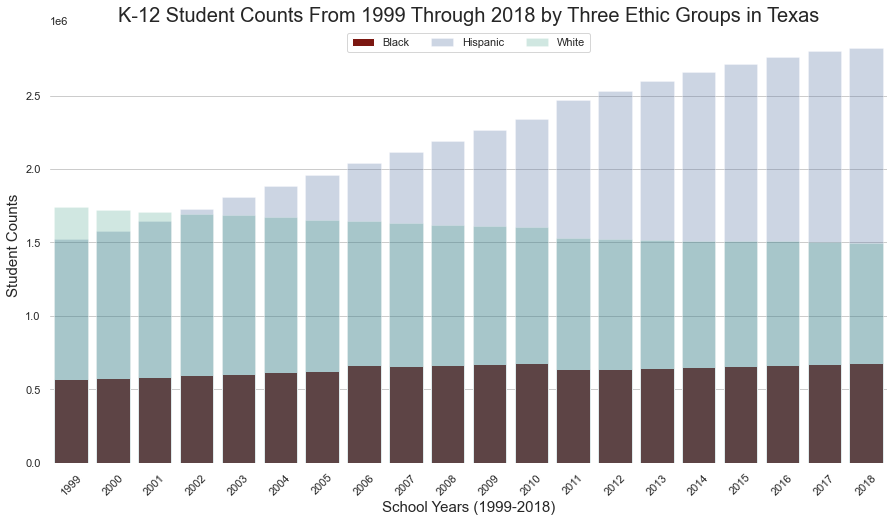

In [67]:
# Use Seaborn to generate static graph

f, ax = plt.subplots(figsize=(15,8))

sns.set_color_codes('dark')
sns.barplot(x='SCHOOL_YR',y='CPETBLAC',data=annual_count_by_ethnic,label="Black",color='r')

sns.set_color_codes('deep')
sns.barplot(x='SCHOOL_YR',y='CPETHISC',data=annual_count_by_ethnic,label="Hispanic",color='b',alpha=0.3)

sns.set_color_codes('colorblind')
sns.barplot(x='SCHOOL_YR',y='CPETWHIC',data=annual_count_by_ethnic,label="White",color='g',alpha=0.2)

ax.legend(ncol=3,loc='upper center',frameon=True)
ax.set_title('K-12 Student Counts From 1999 Through 2018 by Three Ethic Groups in Texas',fontsize=20)
ax.set_xlabel('School Years (1999-2018)', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_ylabel('Student Counts',fontsize=15)

sns.despine(left=True, bottom=True)
ax.get_figure().savefig('barplot_student_counts_from_1999_2018_by_three_ethnic_group.png')

In [73]:
# Use plotly to generate interactive graph

fig = go.Figure()
fig.add_trace(go.Scatter(x=annual_count_by_ethnic['SCHOOL_YR'],
                    y=annual_count_by_ethnic['CPETALLC'],                     
                    mode='lines+markers',
                    name='Total Student',
                    marker_color='indianred'))
fig.add_trace(go.Bar(x=annual_count_by_ethnic['SCHOOL_YR'],
                    y=annual_count_by_ethnic['CPETBLAC'],
                    name='African American',
                    marker_color='teal'))
fig.add_trace(go.Bar(x=annual_count_by_ethnic['SCHOOL_YR'],
                    y=annual_count_by_ethnic['CPETHISC'],
                    name='Hispanic',
                    marker_color='lightsalmon'))
fig.add_trace(go.Bar(x=annual_count_by_ethnic['SCHOOL_YR'],
                    y=annual_count_by_ethnic['CPETWHIC'],
                    name='White',
                    marker_color='skyblue'))
fig.update_layout(title={'text':'K-12 TX Student Counts From 1999 through 2018 by Three Ethnicity Groups',
                        'xanchor':'center',
                         'x':0.44,
                        'yanchor':'top'},
                  width=1000,
                  height=600,
                  xaxis_title="School Years",
                  yaxis_title="Student Count",
                  font={'size':14,
                       'color':'slategrey'},
                  barmode='group', 
                  xaxis_tickangle=-10)
fig.show()
fig.write_html('barplot_student_counts_from_1999_2018_by_three_ethnic_group.html')

### 3) Geographic Illustration of Distribution of K-12 Enrollees by Ethnic Groups

In [144]:
# Read shapefile into a Pandas GeoDataFrame
district_spatial = gpd.read_file('TEA_shapefiles/Districts_2018_2019/Current_Districts.shp')
print(district_spatial.head())
print(district_spatial.info())
print(type(district_spatial))
print(district_spatial.shape)

   feature_id SDLEA10                name           NAME2  DISTRICT_N  \
0           1   40710         Socorro ISD         Socorro       71909   
1           2   13920         Chilton ISD         Chilton       73901   
2           3   11250         Bremond ISD         Bremond      198901   
3           4   30180         Memphis ISD         Memphis       96904   
4           5   34380  Patton Springs ISD  Patton Springs       63906   

  DISTRICT DISTRICT_C NCES_DISTR  COLOR  SHAPE_Leng    SHAPE_Area  \
0  071-909     071909    4840710      6    1.014583  3.443916e+08   
1  073-901     073901    4813920      4    1.108750  2.294086e+08   
2  198-901     198901    4811250      2    1.415892  4.750537e+08   
3  096-904     096904    4830180      7    2.468569  1.729847e+09   
4  063-906     063906    4834380      1    1.483852  1.007704e+09   

                                            geometry  
0  POLYGON ((-106.21499 32.00186, -106.20617 32.0...  
1  POLYGON ((-96.99309 31.40670, -96

In [97]:
# Plot the sptial data with matplotlib built in plot, which can not specify the projection coordinating system
#district_spatial.plot(figsize=(20,15))

In [84]:
#Note that the number of unique districts in 'annual_count_by_yr_district' is greater than that in 'district_spatial', 
#because 'annual_count_by_yr_district' include all the districts from 1999 through 2018, however, some districts have been 
#rezoned, therefore some district IDs may be deleted or reassigned a new ID. The 'district_spatial' spatial file includes 
#the districts for 2019 school year only, which is the latest spatial data available on TEA website. In this project, this 
#spatial data will be used. In the future research, the NCES year-based district spatial polygon files may be added, 
#which need to do matching between the locator ID used in NCES and district ID used in TEA data.
print(district_spatial['DISTRICT_C'].count())
print(annual_count_by_yr_district['DISTRICT'].nunique())

1021
1347


In [119]:
# Merge GeoDataFrame(district_spatial) with DataFrame (annual_count_by_yr_district).
# GeoDataFrame is the left table, and DataFrame is the right table, so that the created merged data still is a GeoDataFrame.
# The new created GeoDataFrame will later be converted to GeoJSON file that can be plotted in Plotly
annual_district_spatial = district_spatial.merge(annual_count_percent_district_1999_2018,
                                                how='inner',
                                                left_on='DISTRICT_N',
                                                right_on='DISTRICT')

In [120]:
annual_district_spatial.head(2)

,feature_id,SDLEA10,name,NAME2,DISTRICT_N,DISTRICT_x,DISTRICT_C,NCES_DISTR,COLOR,SHAPE_Leng,...,geometry,School Years,DISTRICT_y,All Count,Black Count,Hispanic Count,White Count,Black Percentage,Hispanic Percentage,White Percentage
0,1,40710,Socorro ISD,Socorro,71909,071-909,071909,4840710,6,1.014583,...,"POLYGON ((-106.21499 32.00186, -106.20617 32.0...",1999,71909,23566,289,21215,1940,0.012263,0.900238,0.082322
1,1,40710,Socorro ISD,Socorro,71909,071-909,071909,4840710,6,1.014583,...,"POLYGON ((-106.21499 32.00186, -106.20617 32.0...",2000,71909,25305,300,22953,1894,0.011855,0.907054,0.074847


In [121]:
annual_district_spatial.drop(columns=['NAME2','DISTRICT_x','DISTRICT_C','DISTRICT_y'],inplace=True)
annual_district_spatial.rename(columns={'DISTRICT_N':'DISTRICT'},inplace=True)

In [124]:
annual_district_spatial.head(2)

,feature_id,SDLEA10,name,DISTRICT,NCES_DISTR,COLOR,SHAPE_Leng,SHAPE_Area,geometry,School Years,All Count,Black Count,Hispanic Count,White Count,Black Percentage,Hispanic Percentage,White Percentage
0,1,40710,Socorro ISD,71909,4840710,6,1.014583,3.443916e+08,"POLYGON ((-106.21499 32.00186, -106.20617 32.0...",1999,23566,289,21215,1940,0.012263,0.900238,0.082322
1,1,40710,Socorro ISD,71909,4840710,6,1.014583,3.443916e+08,"POLYGON ((-106.21499 32.00186, -106.20617 32.0...",2000,25305,300,22953,1894,0.011855,0.907054,0.074847


In [96]:
# Use Geoplot to do geospatial visualization, which can specify the projection coordinating system
#import geoplot
#geoplot.polyplot(annual_district_spatial,figsize=(20,15))

# Specify the "Orthographic" map projection(e.g. a world globe) provided by CartoPyS
#ax = geoplot.polyplot(annual_district_spatial,
#                     projection=geoplot.crs.Orthographic(),
#                     figsize=(20,15))
#ax.outline_patch.set_visible(True)

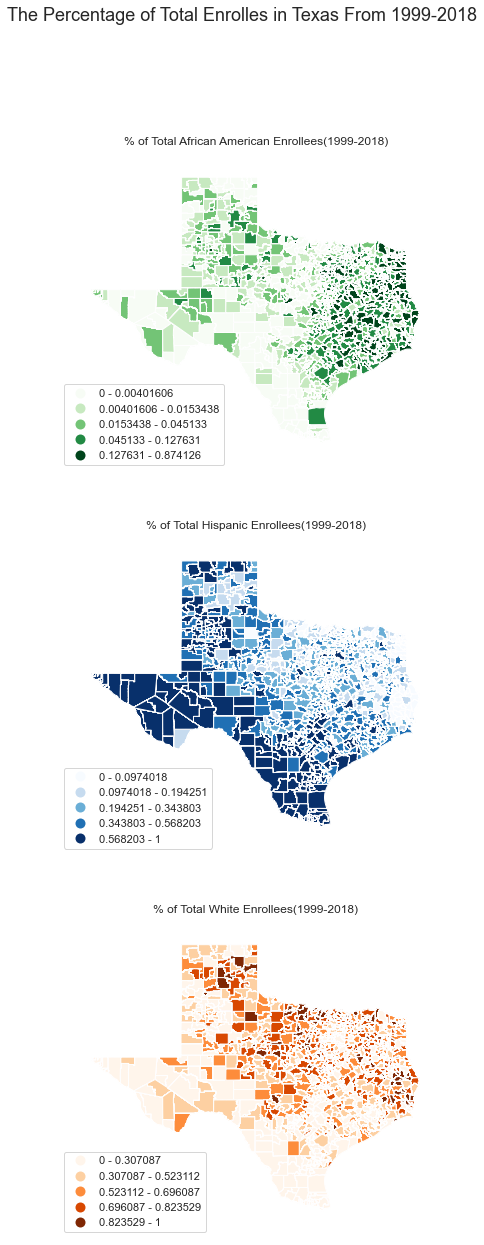

In [125]:
# Create choropleth maps to present the percentage of enrollees in three ethnic groups in Texas from 1999 through 2018 
# "geoplot.polyplot" is trivial and can only plot the geometries we pass to it.If we want to use color as a visual variable, 
# we can specify a "choropleth"."mapclassify" is for Choropleth map classification, it is part of PySAL
import geoplot
import mapclassify

blac_perc = annual_district_spatial['Black Percentage']
hisp_perc = annual_district_spatial['Hispanic Percentage']
whit_perc = annual_district_spatial['White Percentage']

scheme_blac = mapclassify.Quantiles(blac_perc,k=5)
scheme_hisp = mapclassify.Quantiles(hisp_perc,k=5)
scheme_whit = mapclassify.Quantiles(whit_perc,k=5)

fig = plt.figure(figsize=(15,20))
fig.suptitle('The Percentage of Total Enrolles in Texas From 1999-2018',fontsize=18)

ax_blac = fig.add_subplot(3,1,1)
ax_blac.set_title('% of Total African American Enrollees(1999-2018)',fontsize=12)
geoplot.choropleth(annual_district_spatial,hue=blac_perc,scheme=scheme_blac,
                  cmap='Greens',ax=ax_blac,legend=True)

ax_hisp = fig.add_subplot(3,1,2)
ax_hisp.set_title('% of Total Hispanic Enrollees(1999-2018)',fontsize=12)
geoplot.choropleth(annual_district_spatial,hue=hisp_perc,scheme=scheme_hisp,
                  cmap='Blues',ax=ax_hisp,legend=True)

ax_whit = fig.add_subplot(3,1,3)
ax_whit.set_title('% of Total White Enrollees(1999-2018)',fontsize=12)
geoplot.choropleth(annual_district_spatial,hue=whit_perc,scheme=scheme_whit,
                  cmap='Oranges',ax=ax_whit,legend=True)

plt.savefig('The_Percentage_of_Total_Enrolles_in_Texas_by_Three_Ethnicity_Groups_From_1999_2018.png')

#### The maps above indicate that in the past 20 years from 1999 through 2018: (1) High percentage of African American students were enrolled in the school districts located in the east of Texas; (2) High percentage of Hispanic students were enrolled in the school districts located in the south west  of Texas; (3) High percentage of White students were enrolled in the school districts located in the north of Texas and far east of Texas.

In [128]:
# Geogrphically visulize the trends of enrollees in three ethnic groups in the past 20 years 
# by plotting the distributions of the enrollees every 10 years from 1999 through 2008 and 2009 through 2018.

ethnic_group = ['black','white','hispanic']
for start_yr in range(1999,2018,10):
    # calculate end_yr 
    end_yr = start_yr + 9
    for ethnic in ethnic_group:
        ethnic_var = 'others'
        all_count = 'All Count'
        if ethnic == 'black':
            ethnic_var = 'Black Count'
        elif ethnic == 'white':
            ethnic_var = 'Hispanic Count'
        elif ethnic == 'hispanic':
            ethnic_var = 'White Count'
        # calculate the list of the enrollee counts in a specified ethnic group in a specified start year    
        start = annual_district_spatial[annual_district_spatial['School Years']==start_yr][ethnic_var]
        start.reset_index(drop=True,inplace=True)
        # calculate the list of the enrollee counts in a specified ethnic group in a specified end year
        end = annual_district_spatial[annual_district_spatial['School Years']==end_yr][ethnic_var]
        end.reset_index(drop=True,inplace=True)

        # calculate the percentage of the enrollee counts between the start year and the end year
        change_per = (end-start)/start
        
        exec("change_per_" + str(start_yr) + "_" + str(end_yr) + "_" + ethnic + "= change_per")


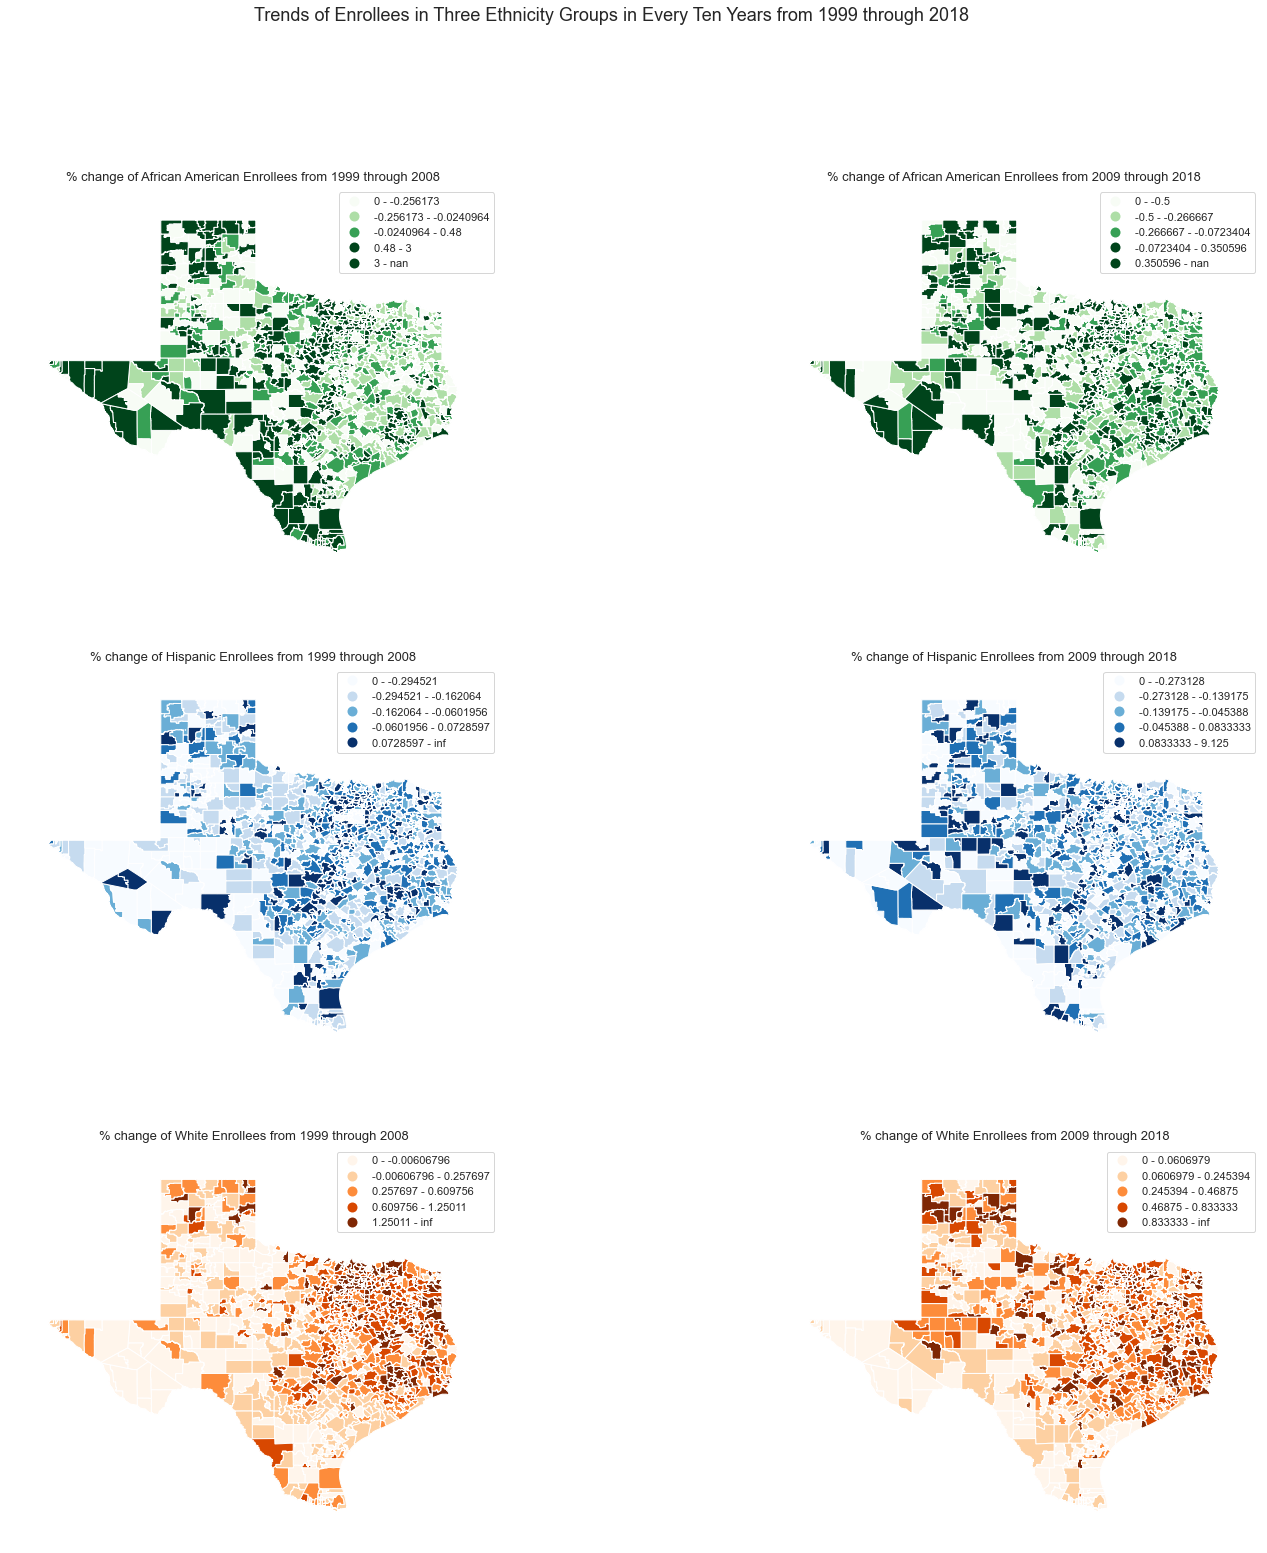

In [129]:
# Geographic plotting
fig = plt.figure(figsize=(25,25))
#fig.layout.update(margin={'r':0,'t':0,'l':0,'b':0})
fig.suptitle('Trends of Enrollees in Three Ethnicity Groups in Every Ten Years from 1999 through 2018',fontsize=18)

scheme_black_1999_2008 = mapclassify.Quantiles(change_per_1999_2008_black,k=5)
ax_black_1999_2008 = fig.add_subplot(3,2,1)
ax_black_1999_2008.set_title("% change of African American Enrollees from 1999 through 2008",fontsize=13)
geoplot.choropleth(annual_district_spatial[annual_district_spatial['School Years']==1999],
                   hue=list(change_per_1999_2008_black),
                   scheme=scheme_black_1999_2008,
                   cmap='Greens',
                   ax=ax_black_1999_2008,
                   legend=True)

scheme_black_2009_2018 = mapclassify.Quantiles(change_per_2009_2018_black,k=5)
ax_black_2009_2018 = fig.add_subplot(3,2,2)
ax_black_2009_2018.set_title("% change of African American Enrollees from 2009 through 2018",fontsize=13)
geoplot.choropleth(annual_district_spatial[annual_district_spatial['School Years']==2009],
                   hue=list(change_per_2009_2018_black),
                   scheme=scheme_black_2009_2018,
                   cmap='Greens',
                   ax=ax_black_2009_2018,
                   legend=True)

scheme_hispanic_1999_2008 = mapclassify.Quantiles(change_per_1999_2008_hispanic,k=5)
ax_hispanic_1999_2008 = fig.add_subplot(3,2,3)
ax_hispanic_1999_2008.set_title("% change of Hispanic Enrollees from 1999 through 2008",fontsize=13)
geoplot.choropleth(annual_district_spatial[annual_district_spatial['School Years']==1999],
                   hue=list(change_per_1999_2008_hispanic),
                   scheme=scheme_hispanic_1999_2008,
                   cmap='Blues',
                   ax=ax_hispanic_1999_2008,
                   legend=True)

scheme_hispanic_2009_2018 = mapclassify.Quantiles(change_per_2009_2018_hispanic,k=5)
ax_hispanic_2009_2018 = fig.add_subplot(3,2,4)
ax_hispanic_2009_2018.set_title("% change of Hispanic Enrollees from 2009 through 2018",fontsize=13)
geoplot.choropleth(annual_district_spatial[annual_district_spatial['School Years']==2009],
                   hue=list(change_per_2009_2018_hispanic),
                   scheme=scheme_hispanic_2009_2018,
                   cmap='Blues',
                   ax=ax_hispanic_2009_2018,
                   legend=True)

scheme_white_1999_2008 = mapclassify.Quantiles(change_per_1999_2008_white,k=5)
ax_white_1999_2008 = fig.add_subplot(3,2,5)
ax_white_1999_2008.set_title("% change of White Enrollees from 1999 through 2008",fontsize=13)
geoplot.choropleth(annual_district_spatial[annual_district_spatial['School Years']==1999],
                   hue=list(change_per_1999_2008_white),
                   scheme=scheme_white_1999_2008,
                   cmap='Oranges',
                   ax=ax_white_1999_2008,
                   legend=True)

scheme_white_2009_2018 = mapclassify.Quantiles(change_per_2009_2018_white,k=5)
ax_white_2009_2018 = fig.add_subplot(3,2,6)
ax_white_2009_2018.set_title("% change of White Enrollees from 2009 through 2018",fontsize=13)
geoplot.choropleth(annual_district_spatial[annual_district_spatial['School Years']==2009],
                   hue=list(change_per_2009_2018_white),
                   scheme=scheme_white_2009_2018,
                   cmap='Oranges',
                   ax=ax_white_2009_2018,
                   legend=True)

plt.savefig('Percentage Change of Enrollees in Three Ethnicity Groups in Every Ten Years from 1999 through 2018')

### 4) Build a web-based Dashboard with Dash

In [3]:
# Load 2018 TEA district shapefile, 
# this project only uses 2018 shapefile
tea_shape_2018 = gpd.read_file('TEA_shapefiles/Districts_2018_2019/Current_Districts.shp') # 2018 TEA district shapefile
tea_shape_2018 = tea_shape_2018[['DISTRICT_N','SDLEA10','name','geometry']] # keep useful variables
tea_shape_2018.to_file('tea_geojson_2018.geojson',driver='GeoJSON') # convert to GeoJSON file

In [145]:
# Build a web-based Dashboard with Dash
# "student_enroll_dash.py"

import pandas as pd
import plotly.graph_objects as go

# The jupyter-dash package makes it easy to develop Plotly Dash apps from the Jupyter Notebook and JupyterLab.
# Just replace the standard dash.Dash class with the jupyter_dash.JupyterDash subclass.
# When running in JupyterHub or Binder, call the infer_jupyter_config function to detect the proxy configuration.
# JupyterDash.infer_jupyter_proxy_config()
#from jupyter_dash import JupyterDash

import dash  
import dash_core_components as dcc 
import dash_html_components as html 
from dash.dependencies import Input, Output, State



# MapBox PK
my_pk_token='pk.eyJ1IjoibWFya2x1IiwiYSI6ImNrY2R1Z2w1dTAyMGQzN281dmNvdThwNncifQ.qSI-FTbzPLiDRms5V-2m-Q'

# Reset the working directory
import os
working_path='C:/Users/markl/Documents/Python Scripts/projects/education'
os.chdir(working_path)
print (os.getcwd())

# ------------------------------------------------------------------------------
# -----1 Plotly Graph Part (Data preparation part):-----

# Import enrollment data
tea_1999_2018 = pd.read_csv('annual_count_percent_district_1999_2018.csv')
tea_1999_2018.head(2)
tea_1999_2018.info()

# Limit percentages to four decimal points
tea_1999_2018['Black Percentage']=tea_1999_2018['Black Percentage'].map('{:,.4f}'.format)
tea_1999_2018['Hispanic Percentage']=tea_1999_2018['Hispanic Percentage'].map('{:,.4f}'.format)
tea_1999_2018['White Percentage']=tea_1999_2018['White Percentage'].map('{:,.4f}'.format) 


# load GeoJSON file

#from urllib.request import urlopen
#import json
#with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
#    gjson_file = json.load(response)

# Simplify the original GeoJSON file using "https://mapshaper.org/"
import json
with open('tea_geojson_2018_2.geojson') as geojson_file:
    gjson_file = json.load(geojson_file)

gjson_file['features'][0].keys()
    
# Add a key called 'id' to GeoJSON file
# 'id' is District ID number
i=0
for feature in gjson_file['features']:
    feature['id'] = gjson_file['features'][i]['properties']['DISTRICT_N']
    i += 1

#tea_district_name_list = [feat['properties']['name']  for feat in gjson_file['features'] if feat['id'] in gjson_district_list] # District names list

# Year List
slide_yr = tea_1999_2018['School Years'].unique()

# Ethnicities List
ethnic_list = ['Black','Hispanic','White']


# ------------------------------------------------------------------------------
# -----2 Dash Components Preparation Part:-----

# App layout

app = dash.Dash(__name__)
server = app.server # the Flask app

app.layout = html.Div([
    
    # Dash app title
    html.H1("The Student Enrollment Across School Districts in Texas From 1999 through 2018", style={'text-align': 'center'}),
    
    # Dash component1: Slider for school years
    html.Div(dcc.Slider(
            id='school-year-slider',
            min=slide_yr.min(),
            max=slide_yr.max(),
            value=slide_yr.min(), # default value
            step=1,
            marks={str(year): str(year) for year in slide_yr}, # years list
            included=False),
            style={'width':'95%', 'padding':'0px 20px 20px 20px'}),
    
    # Dash component2: Dropdown for ethnic
    html.Div([
            dcc.Dropdown(
                    id='ethnic-list',
                    options=[{'label':i,'value':i} for i in ethnic_list], # ethnic list
                    multi=False,
                    value='Black')
            ]),
    
    html.Br(),        
    
    # Dash component3: RadioItes for showing type (percentage or count)
    html.Div([
            dcc.RadioItems(
                    id='show-type',
                    options=[{'label':i,'value':i} for i in ['Percentage','Count']],
                    value='Percentage',
                    labelStyle={'dispaly':'inline-block'},
                    ),     
            ]),
               
    html.Br(),
    
    html.Div(id='note-description', 
             children=[], 
             style={'text-align': 'left',
                    'font-size':'11px'}), 
        
    html.Div(
            dcc.Loading(dcc.Graph(id='choroplethmapbox-map', figure={})),
            ),
    
])
    
# ------------------------------------------------------------------------------
# -----3 Callback Part:-----
# Connect the Plotly graphs with Dash Components
@app.callback(
        [Output('choroplethmapbox-map','figure'),
         Output('note-description', 'children')],
         
        [Input('school-year-slider','value'),
         Input('ethnic-list','value'),
         Input('show-type','value')]
        )

def update_graph(year, ethnic, show_type):

    ethnic_and_type = ethnic + ' ' + show_type

    note_desc = "(*The figure presents: {}-{}-{})".format(year,ethnic,show_type)
    
    # Filter the dataframe based on selected "year", and set 'district ID' as index, which can match 'ID' in GeoJSON file
    df=tea_1999_2018[tea_1999_2018['School Years']==year].rename(columns={'DISTRICT':'id'}).set_index('id')
    # Use District ID list as the value of parameter "locations" in go.Chorolethmapbox
    locations = list(df.index)
    # Use District Name list as the values of paramerter "text", which is associated with "locations"
    dist_name = list(df['DISTNAME'])
    # Filter the series based on ethnic and show_type, and then assign to "z"
    z_value=df[ethnic_and_type]
    # Customize the title of each rendered figure
    if ethnic=='Black':
        ethnic_in_title_word = 'African American'
    else:
        ethnic_in_title_word = ethnic
        
        
    if show_type=='Count':
        show_type_in_title_word = 'Number'
    else:
        show_type_in_title_word = 'Percentage'
        
    
    fig = go.Figure(
             data=[go.Choroplethmapbox(
                     z=z_value,
                     geojson=gjson_file,
                     locations=locations, # come from the same data file as z value
                     colorscale='Blues',
                     colorbar=dict(thickness=20,ticklen=3),
                     text=dist_name, # comes from the same data file as z value
                     hoverinfo='all',
                     marker_line_width=1,
                     marker_opacity=0.55,
                     name="{}\n{}".format(year,ethnic),
                     )]
             )
    
    fig.update_layout(
            # Customize the title for each rendered map every time the "input" change 
            title_text='The ' + show_type_in_title_word + ' of ' + ethnic_in_title_word + ' Students in ' + str(year),
            height=750,
            title_x=0.5,
            mapbox_style='basic', # set a default mapbox style
            mapbox_accesstoken=my_pk_token,
            mapbox_zoom=4.9,
            mapbox_center={"lat": 31, "lon": -100}
            )
    # Provide multiple rendering mapbox styles: basic, dark, light, outdoor, satellite-streets
    fig.update_layout(
    annotations=[
        dict(text="Choose a map style:", 
             x=0, xref="paper", 
             y=1.06, yref="paper",
             align="left", 
             showarrow=False)
            ])
        
    button_height = 1.087
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=list([
                    dict(
                        args=['mapbox.style', 'basic'],
                        label='Basic',
                        method='relayout'
                    ),                      
                        dict(
                        args=['mapbox.style', 'dark'],
                        label='Dark',
                        method='relayout'
                    ),                    
                    dict(
                        args=['mapbox.style', 'light'],
                        label='Light',
                        method='relayout'
                    ),
                    dict(
                        args=['mapbox.style', 'outdoors'],
                        label='Outdoors',
                        method='relayout'
                    ),
                    dict(
                        args=['mapbox.style', 'satellite-streets'],
                        label='Satellite',
                        method='relayout'
                    )                               
           
                ]),
                direction='down',
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.13,
                xanchor="left",
                y=button_height,
                yanchor="top"
            )
        ]
    )

    return fig, note_desc   

# ------------------------------------------------------------------------------
if __name__ == '__main__':
    app.run_server(debug=True, port=8054, use_reloader=False) # "use_reloader=False" is needed in jupyter notebook

C:\Users\markl\Documents\Python Scripts\projects\education
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29599 entries, 0 to 29598
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   School Years         29599 non-null  int64  
 1   DISTRICT             29599 non-null  int64  
 2   All Count            29599 non-null  int64  
 3   Black Count          29599 non-null  int64  
 4   Hispanic Count       29599 non-null  int64  
 5   White Count          29599 non-null  int64  
 6   Black Percentage     29599 non-null  float64
 7   Hispanic Percentage  29599 non-null  float64
 8   White Percentage     29599 non-null  float64
 9   DISTNAME             29599 non-null  object 
dtypes: float64(3), int64(6), object(1)
memory usage: 2.3+ MB
Dash is running on http://127.0.0.1:8054/

Dash is running on http://127.0.0.1:8054/

Dash is running on http://127.0.0.1:8054/

Dash is running on http://127.0.0.1:8054/